In [1725]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data normalization and standardization 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
#from fancyimpute import KNN

#Training and testing split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler

#Evalution
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")
sns.set_palette('viridis_r')

## Loading Training/Testing Data:

In [1726]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

train_df = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_df = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')

#Storing house id's for later use in final prediction dataframe
train_df_Id = train_df.index.values
test_df_Id = test_df.index.values

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preprocessing:

In [1727]:
# create df that consists of columns and the number of missing values for each 
data = train_df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

# add column and fill it with the percentage of those missing values
missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/train_df.shape[0] * 100)) 
missing_df = missing_df[missing_df.missing_cnt > 0]
missing_df

,missing_cnt,percent_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageCond,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


In [1728]:
# drop the columns where majority of their values are missing
# train_df = train_df.drop(['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu'], axis = 1)
# train_df.head()

### Label Encoding

In [1729]:
print (train_df.shape)
print (test_df.shape)
# Converting category labels into numerical values

(1460, 80)
(1459, 79)


In [1730]:
# LotShape
lots = {
    "IR3" : 1,
	"IR2" : 2,
	"IR1" : 3,
	"Reg" : 4
}

train_df["LotShape"] = train_df.LotShape.map(lots)
test_df["LotShape"] = test_df.LotShape.map(lots)

In [1731]:
# LandContour
contours= {
	"Low" : 1,
	"HLS" : 2,
	"Bnk" : 3,
	"Lvl" : 4
}

train_df["LandContour"] = train_df.LandContour.map(contours)
test_df["LandContour"] = test_df.LandContour.map(contours)

In [1732]:
# LandSlope
slopes = {
 "Sev" : 1,
 "Mod" : 2,
 "Gtl" : 3
}

train_df["LandSlope"] = train_df.LandSlope.map(slopes)
test_df["LandSlope"] = test_df.LandSlope.map(slopes)

In [1733]:
# BsmtExposure
basement_exposures = {
	"NA" : 1,
	"No" : 2,
	"Mn" : 3,
	"Av" : 4,
	"Gd" : 5
}

train_df["BsmtExposure"] = train_df.BsmtExposure.map(basement_exposures)
test_df["BsmtExposure"] = test_df.BsmtExposure.map(basement_exposures)

In [1734]:
# BsmtFinType1, BsmtFinType2
basement_finishes = {
	"NA" : 1,
	"Unf" : 2,
	"LwQ" : 3,
	"Rec" : 4,
	"BLQ" : 5,
	"ALQ" : 6,
	"GLQ" : 7
}

train_df["BsmtFinType1"] = train_df.BsmtFinType1.map(basement_finishes)
train_df["BsmtFinType2"] = train_df.BsmtFinType2.map(basement_finishes)

test_df["BsmtFinType1"] = test_df.BsmtFinType1.map(basement_finishes)
test_df["BsmtFinType2"] = test_df.BsmtFinType2.map(basement_finishes)

In [1735]:
# Functional
functional_ratings = {
	"Sal" : 1,
	"Sev" : 2,
	"Maj2" : 3,
	"Maj1" : 4,
	"Mod" : 5,
	"Min2" : 6,
	"Min1" : 7,
	"Typ" : 8
}

train_df["Functional"] = train_df.Functional.map(functional_ratings)
test_df["Functional"] = test_df.Functional.map(functional_ratings)

In [1736]:
# GarageFinish
garage_finishes = {
	"NA" : 1,
	"Unf" : 2,
	"RFn" : 3,
	"Fin" : 4
}

train_df["GarageFinish"] = train_df.GarageFinish.map(garage_finishes)
test_df["GarageFinish"] = test_df.GarageFinish.map(garage_finishes)

In [1737]:
# CentralAir
has_central_air = {
	"N" : 1,
	"Y" : 2
}

train_df["CentralAir"] = train_df.CentralAir.map(has_central_air)
test_df["CentralAir"] = test_df.CentralAir.map(has_central_air)

In [1738]:
# PavedDrive
has_paved_drive = {
	"N" : 1,
	"P" : 2,
	"Y" : 3
}
train_df["PavedDrive"] = train_df.PavedDrive.map(has_paved_drive)
test_df["PavedDrive"] = test_df.PavedDrive.map(has_paved_drive)

In [1739]:
# Fence
fence_ratings = {
	"NA" : 1,
	"MnWw" : 2,
	"GdWo" : 3,
	"MnPrv" : 4,
	"GdPrv" : 5
}

train_df["Fence"] = train_df.Fence.map(fence_ratings)
test_df["Fence"] = test_df.Fence.map(fence_ratings)

In [1740]:
# SaleCondition
sale_conditions = {
	"Partial" : 1,
	"Family" : 2,
	"Alloca" : 3,
	"AdjLand" : 4,
	"Abnorml" : 5,
	"Normal" : 6
}

train_df["SaleCondition"] = train_df.SaleCondition.map(sale_conditions)
test_df["SaleCondition"] = test_df.SaleCondition.map(sale_conditions)

In [1741]:
replace_features = ['LotShape', 'LandContour', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
         'Functional', 'GarageFinish', 'CentralAir', 'PavedDrive', 'Fence', 'SaleCondition']

train_df[replace_features] = train_df[replace_features].replace(np.NaN, 1)
test_df[replace_features] = test_df[replace_features].replace(np.NaN, 1)

train_df[replace_features].head(10)

,LotShape,LandContour,LandSlope,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,CentralAir,PavedDrive,Fence,SaleCondition
Id,,,,,,,,,,,,
1,4,4,3,2.0,7.0,2.0,8,3.0,2,3,1.0,6
2,4,4,3,5.0,6.0,2.0,8,3.0,2,3,1.0,6
3,3,4,3,3.0,7.0,2.0,8,3.0,2,3,1.0,6
4,3,4,3,2.0,6.0,2.0,8,2.0,2,3,1.0,5
5,3,4,3,4.0,7.0,2.0,8,3.0,2,3,1.0,6
6,3,4,3,2.0,7.0,2.0,8,2.0,2,3,4.0,6
7,4,4,3,4.0,7.0,2.0,8,3.0,2,3,1.0,6
8,3,4,3,3.0,6.0,5.0,8,3.0,2,3,1.0,6
9,4,4,3,2.0,2.0,2.0,7,2.0,2,3,1.0,5


In [1742]:
# creating a generic dictionary to hold numercial values to represent categorical values
# for quality related columns (ExterQual, BsmtQual)

quality_ratings = {
 'NA':0,
 'Po':1, 
 'Fa':2, 
 'TA':3, 
 'Gd':3, 
 'Ex':5
}

In [1743]:
# Converting category labels to numerical values for ExterQual column
train_df['ExterQual'] = train_df.ExterQual.map(quality_ratings)
test_df['ExterQual'] = test_df.ExterQual.map(quality_ratings)

# Converting category labels to numerical values for ExterCond column
train_df['ExterCond'] = train_df.ExterCond.map(quality_ratings)
test_df['ExterCond'] = test_df.ExterCond.map(quality_ratings)

In [1744]:
# Converting category labels to numerical values for BsmtQual column
train_df['BsmtQual'] = train_df.BsmtQual.map(quality_ratings)
test_df['BsmtQual'] = train_df.BsmtQual.map(quality_ratings)

# Converting category labels to numerical values for BsmtCond column
train_df['BsmtCond'] = train_df.BsmtCond.map(quality_ratings)
test_df['BsmtCond'] = train_df.BsmtCond.map(quality_ratings)

In [1745]:
# Converting category labels to numerical values for HeatingQC column
train_df['HeatingQC'] = train_df.HeatingQC.map(quality_ratings)
test_df['HeatingQC'] = train_df.HeatingQC.map(quality_ratings)

In [1746]:
# Converting category labels to numerical values for FireplaceQu column
train_df['FireplaceQu'] = train_df.FireplaceQu.map(quality_ratings)
test_df['FireplaceQu'] = train_df.FireplaceQu.map(quality_ratings)

In [1747]:
# Converting category labels to numerical values for KitchenQual column
train_df['KitchenQual'] = train_df.KitchenQual.map(quality_ratings)
test_df['KitchenQual'] = train_df.KitchenQual.map(quality_ratings)

In [1748]:
# Converting category labels to numerical values for GarageQual column
train_df['GarageQual'] = train_df.GarageQual.map(quality_ratings)
test_df['GarageQual'] = train_df.GarageQual.map(quality_ratings)

# Converting category labels to numerical values for GarageCond column
train_df['GarageCond'] = train_df.GarageCond.map(quality_ratings)
test_df['GarageCond'] = train_df.GarageCond.map(quality_ratings)

In [1749]:
# Converting category labels to numerical values for PoolQC column
train_df['PoolQC'] = train_df.PoolQC.map(quality_ratings)
test_df['PoolQC'] = train_df.PoolQC.map(quality_ratings)

In [1750]:
#quality_features = ['ExterQual', 'BsmtQual', 'HeatingQC', 'FireplaceQu',
#                    'KitchenQual', 'GarageQual', 'PoolQC']
#train_df['Quality_Sum'] = train_df[quality_features].sum(axis=1)
#train_df['Quality_Count'] = train_df[quality_features].count(axis=1)
#train_df['Quality_Average'] = train_df['Quality_Sum'] / train_df['Quality_Count'] 
#train_df['Quality_Ratio_'] = train_df['Quality_Average'] / train_df.OverallQual

In [1751]:
replace_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'FireplaceQu',
                    'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC']

train_df[replace_features] = train_df[replace_features].replace(np.NaN, 0)
test_df[replace_features] = test_df[replace_features].replace(np.NaN, 0)

train_df[replace_features].head(10)

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,FireplaceQu,KitchenQual,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,3,3,3.0,3.0,5,0.0,3,3.0,3.0,0.0
2,3,3,3.0,3.0,5,3.0,3,3.0,3.0,0.0
3,3,3,3.0,3.0,5,3.0,3,3.0,3.0,0.0
4,3,3,3.0,3.0,3,3.0,3,3.0,3.0,0.0
5,3,3,3.0,3.0,5,3.0,3,3.0,3.0,0.0
6,3,3,3.0,3.0,5,0.0,3,3.0,3.0,0.0
7,3,3,5.0,3.0,5,3.0,3,3.0,3.0,0.0
8,3,3,3.0,3.0,5,3.0,3,3.0,3.0,0.0
9,3,3,3.0,3.0,3,3.0,3,2.0,3.0,0.0


In [1752]:
#print (train_df.shape)
#print (test_df.shape)
#train_df = pd.get_dummies(data=train_df , columns=['MSZoning','Street', 'Alley', 'Utilities', 'LotConfig',
#                                                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
#                                                   'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
#                                                   'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
#                                                   'Electrical', 'GarageType', 'MiscFeature', 'SaleType'])
#train_df.head()
train_df = train_df.drop(['MSZoning','Street', 'Alley', 'Utilities', 'LotConfig',
                          'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                          'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                          'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                          'Electrical', 'GarageType', 'MiscFeature', 'SaleType'], axis=1)

#test_df = pd.get_dummies(data=test_df , columns=['MSZoning','Street', 'Alley', 'Utilities', 'LotConfig',
#                                                 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
#                                                 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
#                                                'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
#                                                 'Electrical', 'GarageType', 'MiscFeature', 'SaleType'])
#test_df.head()

test_df = test_df.drop(['MSZoning','Street', 'Alley', 'Utilities', 'LotConfig',
                          'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                          'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                          'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                          'Electrical', 'GarageType', 'MiscFeature', 'SaleType'], axis=1)

#print (train_df.shape)
#print (test_df.shape)

In [1753]:
train_df = train_df.apply(lambda x: x.fillna(0))
test_df = test_df.apply(lambda x: x.fillna(0))

In [1754]:
# create df that consists of columns and the number of missing values for each 
data = train_df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

# add column and fill it with the percentage of those missing values
missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/train_df.shape[0] * 100)) 
missing_df = missing_df[missing_df.missing_cnt > 0]
missing_df

,missing_cnt,percent_missing


In [1755]:
train_df.isnull().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
LotShape         0
LandContour      0
LandSlope        0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
CentralAir       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

## Exploratory Data Analysis (EDA)

In [1756]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
corr_matrix['SalePrice']

MSSubClass      -0.0843
LotFrontage      0.2096
LotArea          0.2638
LotShape        -0.2678
LandContour     -0.0730
LandSlope       -0.0512
OverallQual      0.7910
OverallCond     -0.0779
YearBuilt        0.5229
YearRemodAdd     0.5071
MasVnrArea       0.4726
ExterQual        0.4635
ExterCond        0.1260
BsmtQual         0.5213
BsmtCond         0.1971
BsmtExposure     0.3747
BsmtFinType1     0.3049
BsmtFinSF1       0.3864
BsmtFinType2    -0.0053
BsmtFinSF2      -0.0114
BsmtUnfSF        0.2145
TotalBsmtSF      0.6136
HeatingQC        0.4376
CentralAir       0.2513
1stFlrSF         0.6059
2ndFlrSF         0.3193
LowQualFinSF    -0.0256
GrLivArea        0.7086
BsmtFullBath     0.2271
BsmtHalfBath    -0.0168
FullBath         0.5607
HalfBath         0.2841
BedroomAbvGr     0.1682
KitchenAbvGr    -0.1359
KitchenQual      0.5213
TotRmsAbvGrd     0.5337
Functional       0.1076
Fireplaces       0.4669
FireplaceQu      0.5188
GarageYrBlt      0.2614
GarageFinish     0.5492
GarageCars      

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

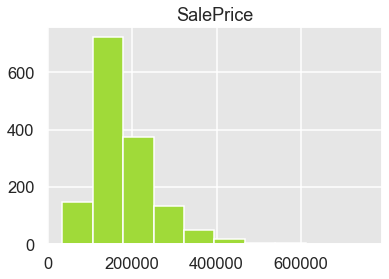

In [1757]:
# check distribution of sales price
train_df.hist(column='SalePrice')

array([[<AxesSubplot:title={'center':'LogPrice'}>]], dtype=object)

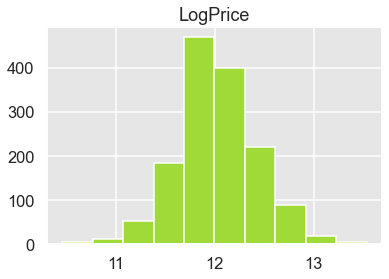

In [1758]:
# normalize sale price so that it can be evenly distributed
train_df['LogPrice'] = np.log(train_df.SalePrice)
train_df.hist(column='LogPrice')

In [1759]:
# check for more skewed columns
train_df.skew().sort_values(ascending=False).head(30)

MiscVal          24.476794
PoolQC           16.848619
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
ExterQual         4.343541
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
BsmtFinType2      3.296996
EnclosedPorch     3.089872
KitchenQual       2.741513
MasVnrArea        2.677616
OpenPorchSF       2.364342
SalePrice         1.882876
Fence             1.807151
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtExposure      1.102968
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
dtype: float64

In [1760]:
# looking at correlation of numeric features to SalePrice column. 
# this will suggest which columns have a greater relationship with the SalePrice column 
corr = train_df.corr().abs().unstack().sort_values(ascending=False)['LogPrice']
corr = corr.iloc[1:]
corr = pd.DataFrame(corr, columns = ['Correlation'])

corr = corr[corr.Correlation > 0.50]
corr

,Correlation
SalePrice,0.948374
OverallQual,0.817184
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
GarageFinish,0.604878
1stFlrSF,0.596981
FullBath,0.594771
YearBuilt,0.586570


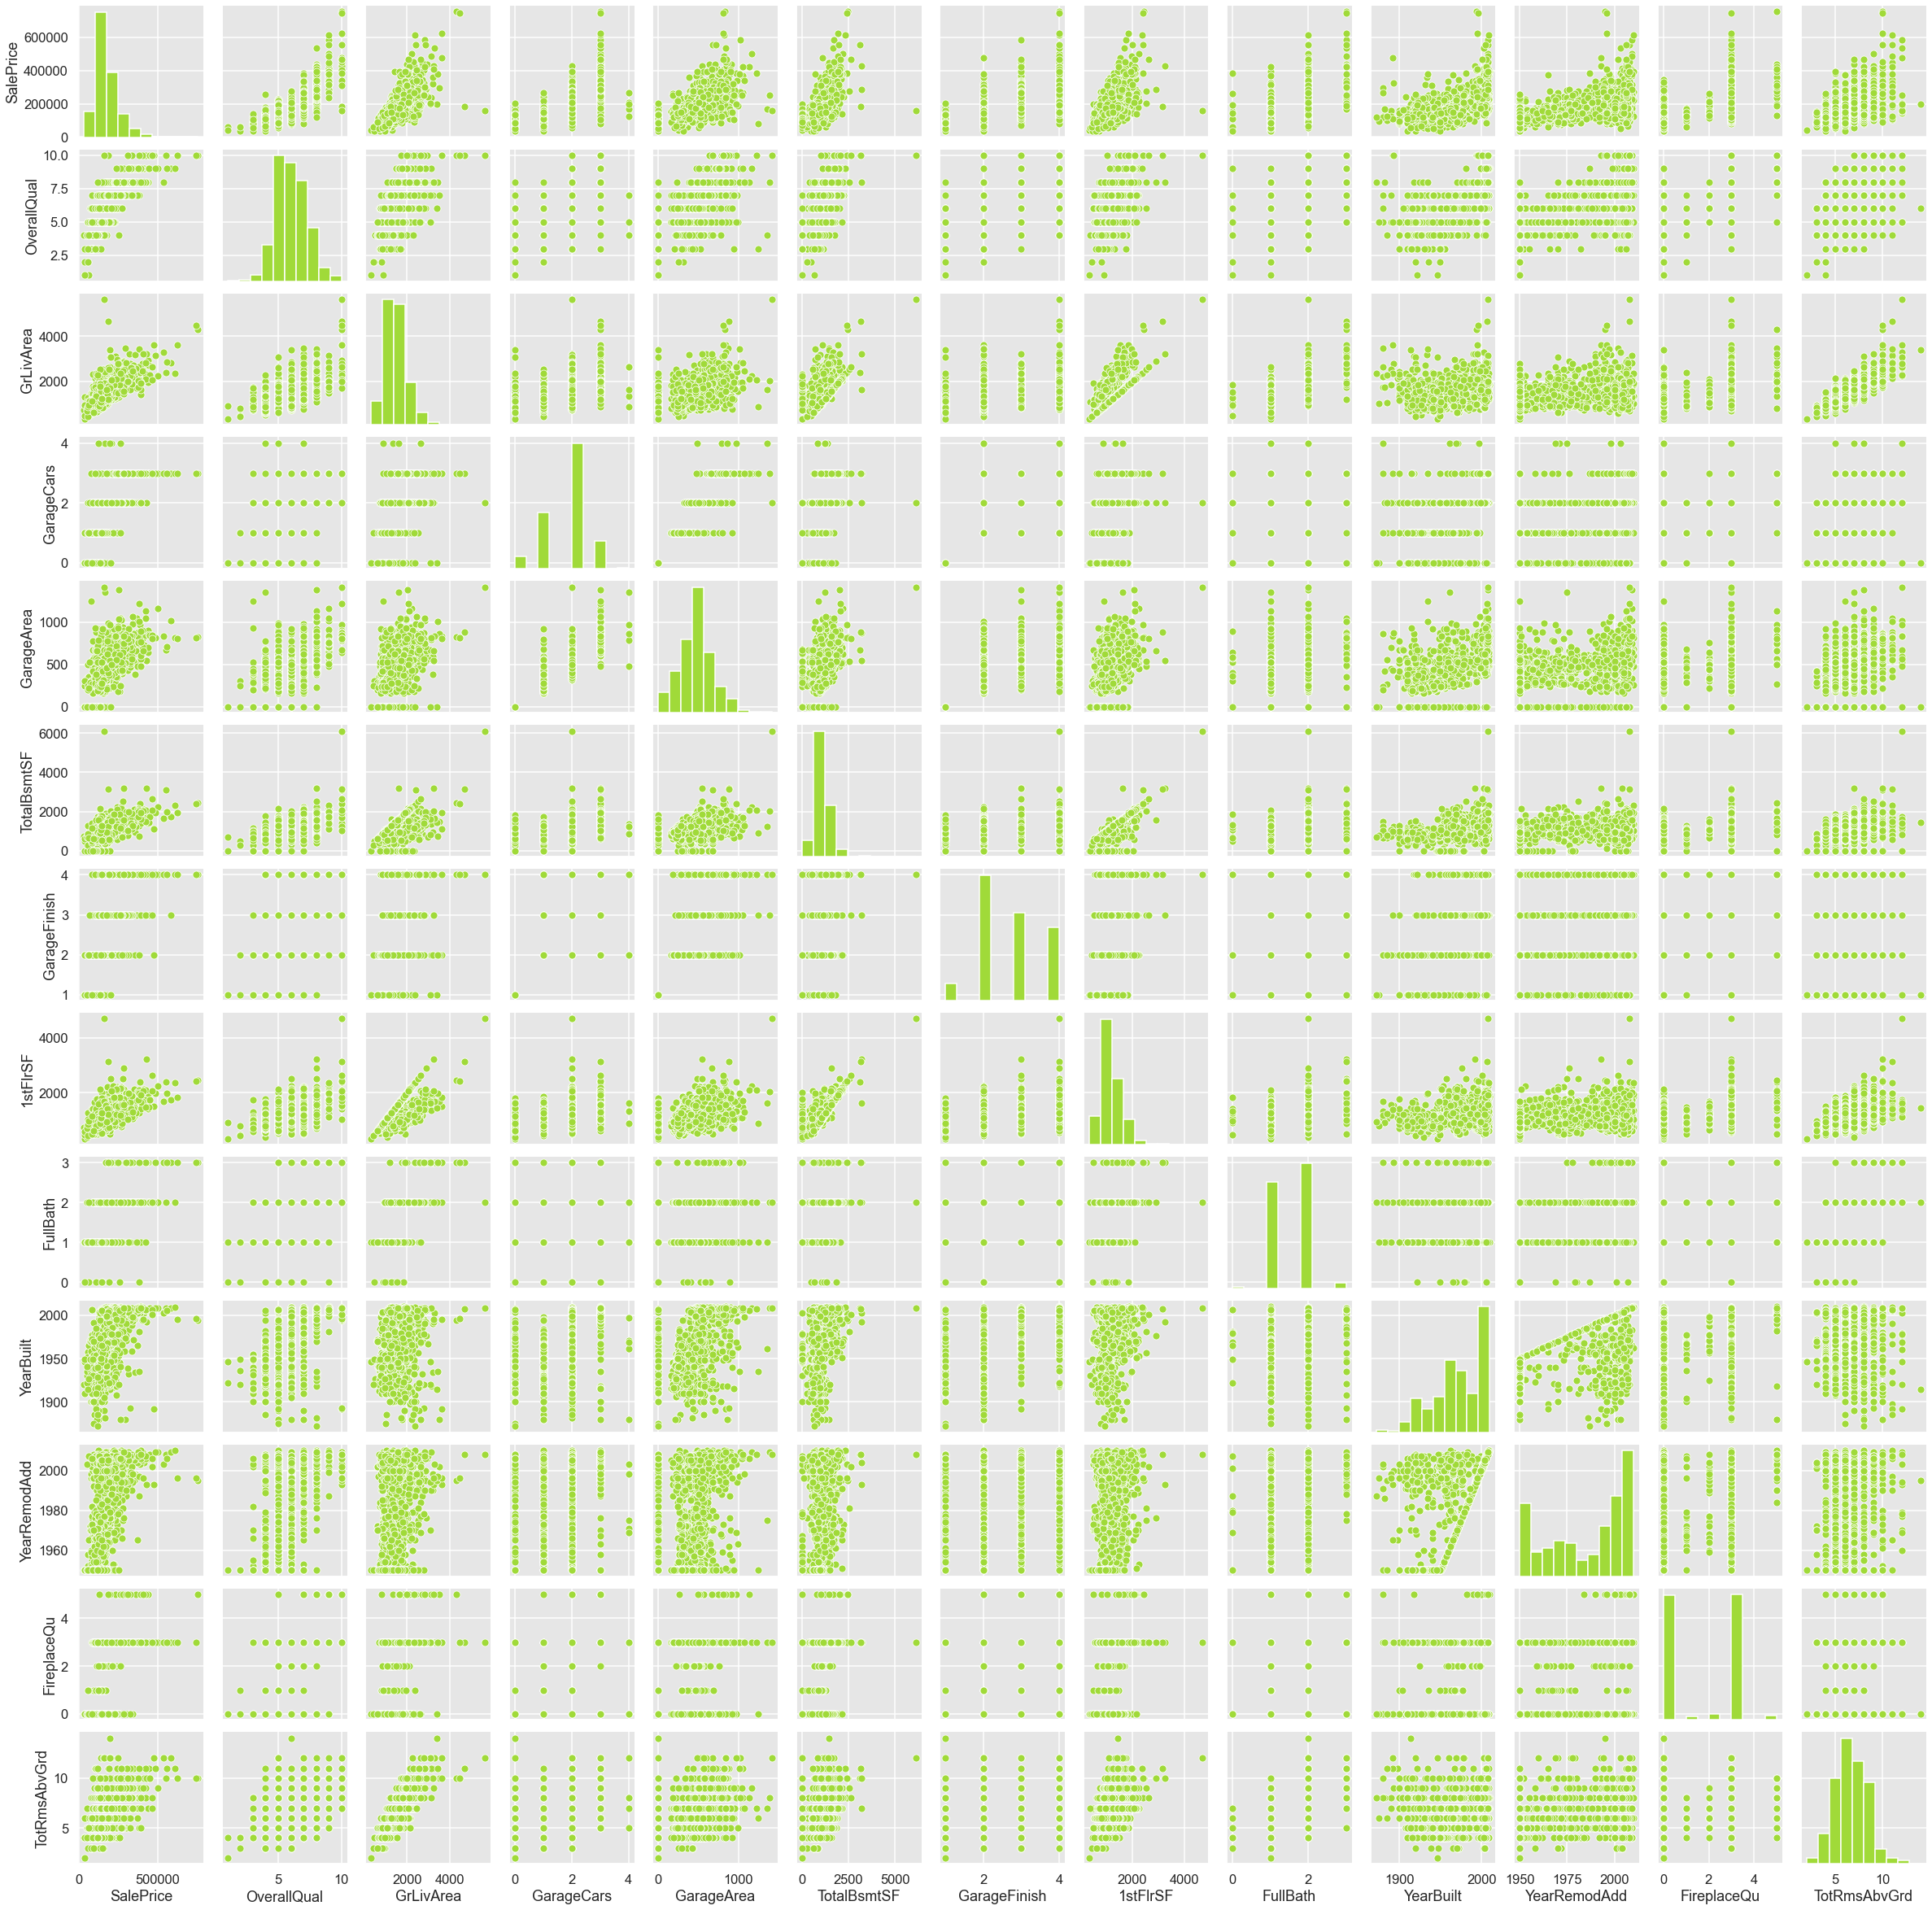

In [1761]:
cols = []
for ind in corr.index:
    cols.append(ind)

# create pair plot between columns that have correlation 50% and above
sns.pairplot(train_df[cols])

### Data Visualization (CAN BE DELETED):

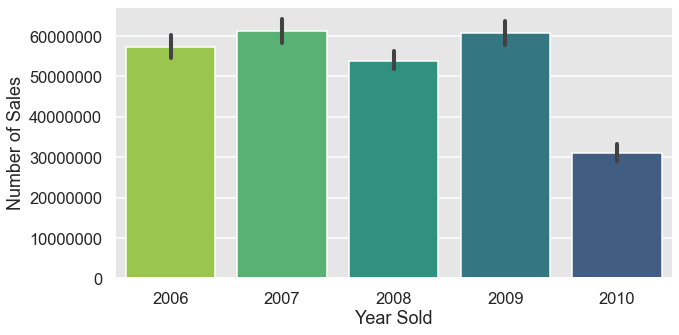

In [1762]:
#Count the number of houses sold in a year
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc='count')
#print(year_sold_pivot)

# Plotting the sum of sales per year
plt.figure(figsize=(10,5))

#Display number in decimal form, not scientific notation
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=sum)
plt.xlabel('Year Sold')
plt.ylabel('Number of Sales')
plt.show()

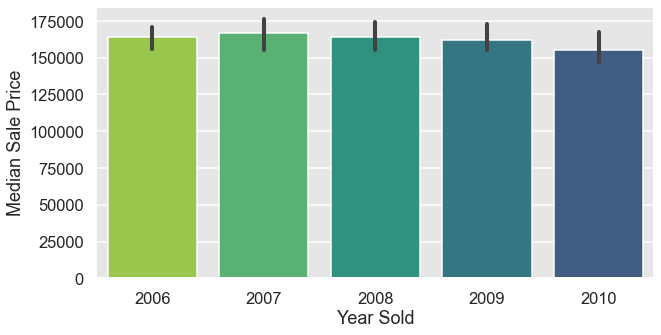

In [1763]:
# Plotting the median sale price for each year

#Checking the median price
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc=np.median)
#print(year_sold_pivot)

plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=np.median)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

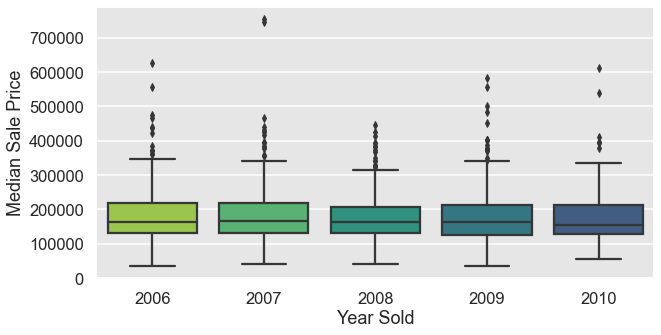

In [1764]:
#Displaying the median price for each year using box plot.  
plt.figure(figsize=(10,5))
sns.boxplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']])
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

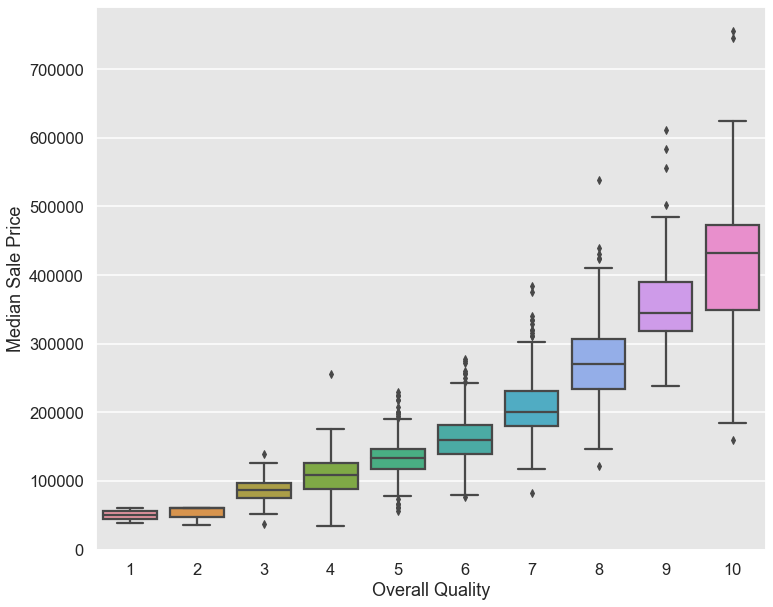

In [1765]:
# Displaying the median price based on overall quality of the house using box plot.
plt.figure(figsize=(12,10))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df[['SalePrice', 'OverallQual']])
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

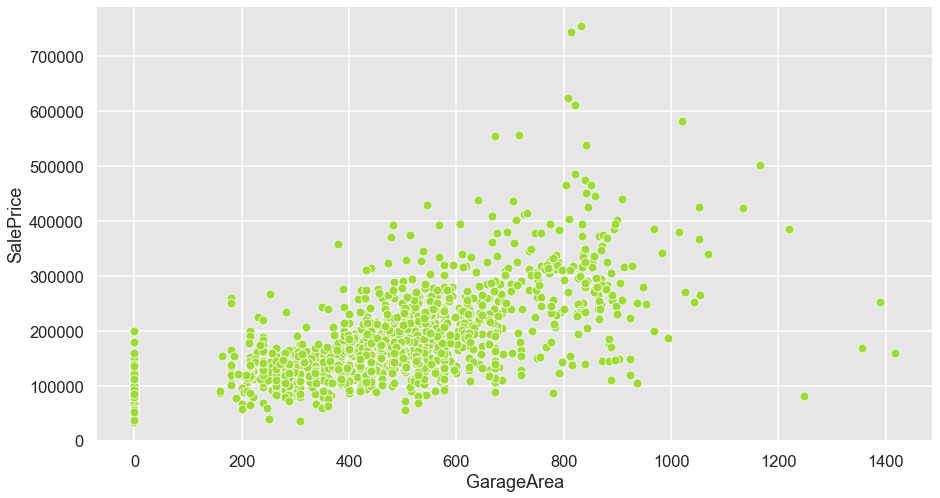

In [1766]:
plt.figure(figsize=(15,8))

# Plot GarageArea vs sale price of house considering the number of cars that can
# fit in the garage
sns.scatterplot(x='GarageArea', y='SalePrice', palette='Set2',
                data=train_df[['SalePrice', 'GarageArea','GarageCars']])
plt.show()

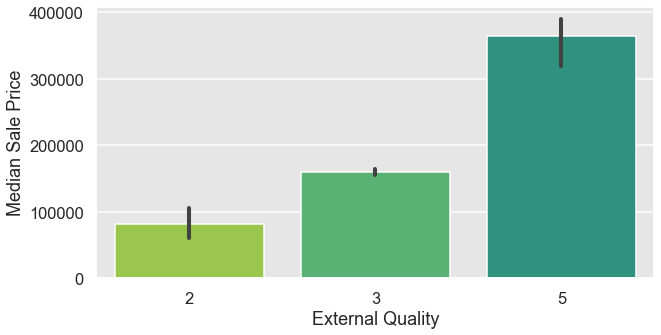

In [1767]:
# Plotting the median sale price based on external quality
plt.figure(figsize=(10,5))
sns.barplot(x='ExterQual', y='SalePrice', data=train_df[['SalePrice', 'ExterQual']], estimator=np.median)
plt.xlabel('External Quality')
plt.ylabel('Median Sale Price')
plt.show()

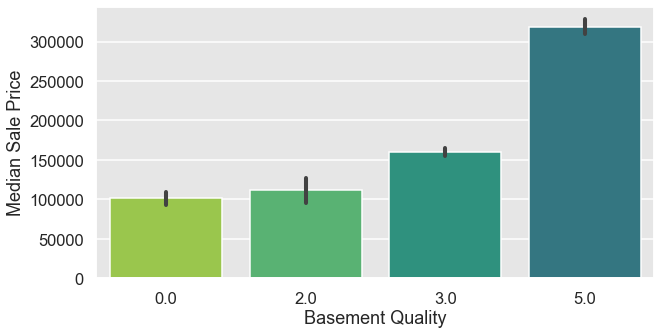

In [1768]:
# Plotting the median sale price based on basement quality
plt.figure(figsize=(10,5))
sns.barplot(x='BsmtQual', y='SalePrice', data=train_df[['SalePrice', 'BsmtQual']], estimator=np.median)
plt.xlabel('Basement Quality')
plt.ylabel('Median Sale Price')
plt.show()

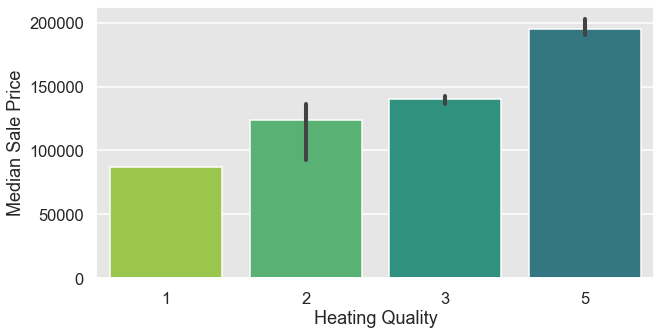

In [1769]:
# Plotting the median sale price based on heating and air conditioning quality
plt.figure(figsize=(10,5))
sns.barplot(x='HeatingQC', y='SalePrice', data=train_df[['SalePrice', 'HeatingQC']], estimator=np.median)
plt.xlabel('Heating Quality')
plt.ylabel('Median Sale Price')
plt.show()

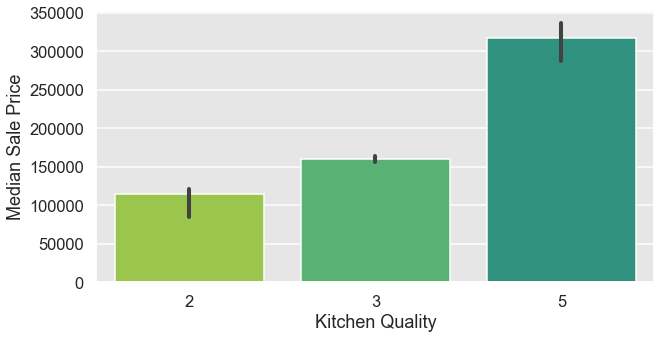

In [1770]:
# Plotting the median sale price based on kitchen quality
plt.figure(figsize=(10,5))
sns.barplot(x='KitchenQual', y='SalePrice', data=train_df[['SalePrice', 'KitchenQual']], estimator=np.median)
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
plt.show()

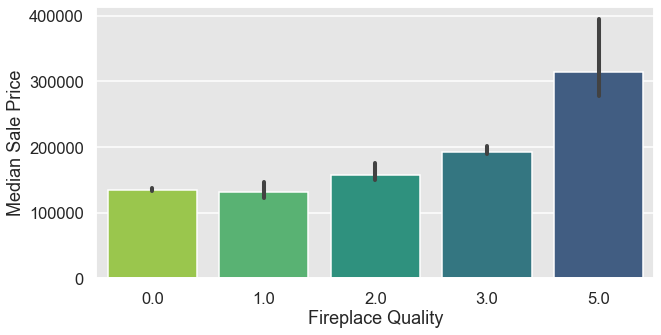

In [1771]:
# Plotting the median sale price based on fireplace quality
plt.figure(figsize=(10,5))
sns.barplot(x='FireplaceQu', y='SalePrice', data=train_df[['SalePrice', 'FireplaceQu']], estimator=np.median)
plt.xlabel('Fireplace Quality')
plt.ylabel('Median Sale Price')
plt.show()

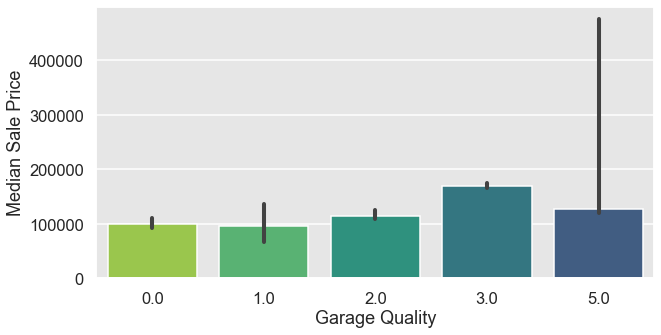

In [1772]:
# Plotting the median sale price based on garage quality

plt.figure(figsize=(10,5))
sns.barplot(x='GarageQual', y='SalePrice', data=train_df[['SalePrice', 'GarageQual']], estimator=np.median)
plt.xlabel('Garage Quality')
plt.ylabel('Median Sale Price')
plt.show()

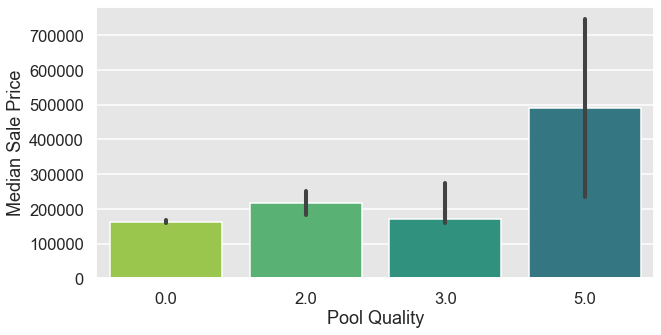

In [1773]:
# Plotting the median sale price based on pool quality
plt.figure(figsize=(10,5))
sns.barplot(x='PoolQC', y='SalePrice', data=train_df[['SalePrice', 'PoolQC']], estimator=np.median)
plt.xlabel('Pool Quality')
plt.ylabel('Median Sale Price')
plt.show()

## Feature Engineering:

### Creating Features

In [1774]:
# sum of quality points.
quality_features = ['ExterQual', 'BsmtQual', 'HeatingQC', 'FireplaceQu',
                    'KitchenQual', 'GarageQual', 'PoolQC']

train_df['QualitySum_'] = train_df[quality_features].sum(axis=1)
train_df['Quality_Count_'] = np.count_nonzero(train_df[quality_features], axis=1)
train_df['Quality_Average_'] = train_df['QualitySum_'] / train_df['Quality_Count_'] 
train_df['Quality_Ratio_'] = train_df.OverallQual / (train_df['Quality_Average_']*2)

test_df['QualitySum_'] = test_df[quality_features].sum(axis=1)
test_df['Quality_Count_'] = np.count_nonzero(test_df[quality_features], axis=1)
test_df['Quality_Average_'] = test_df['QualitySum_'] / test_df['Quality_Count_'] 
test_df['Quality_Ratio_'] = test_df.OverallQual / (test_df['Quality_Average_']*2)

# sum of quality points, removing less correlated features (< 0.5).
high_quality_features = ['BsmtQual', 'FireplaceQu', 'KitchenQual']

train_df['HQ_Sum_'] = train_df[high_quality_features].sum(axis=1)
#train_df['HighQuality_Count_'] = np.count_nonzero(train_df[quality_features], axis=1)
#train_df['HighQuality_Average_'] = train_df['HQ_Sum_'] / train_df['HighQuality_Count_'] 
#train_df['HighQuality_Ratio_'] = train_df['HighQuality_Average_'] / train_df.OverallQual

test_df['HQ_Sum_'] = test_df[high_quality_features].sum(axis=1)
#test_df['HighQuality_Count_'] = np.count_nonzero(test_df[quality_features], axis=1)
#test_df['HighQuality_Average_'] = test_df['HQ_Sum_'] / test_df['HighQuality_Count_'] 
#test_df['HighQuality_Ratio_'] = test_df['HighQuality_Average_'] / test_df.OverallQual

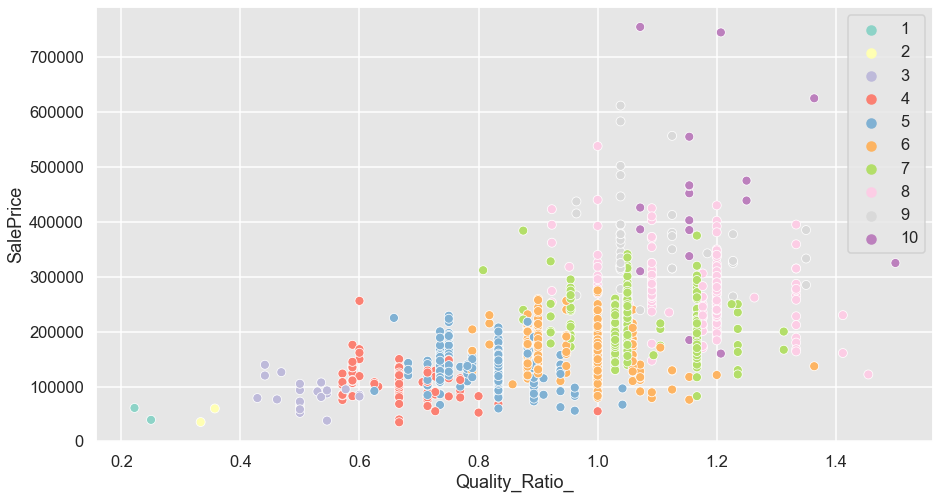

In [1775]:
plt.figure(figsize=(15,8))

# Plot average quality to overall quality
sns.scatterplot(palette='Set3', data=train_df, x='Quality_Ratio_', y='SalePrice', hue=train_df.OverallQual.tolist())
#            data=train_df[['SalePrice', 'Quality_Ratio_', 'OverallQual']])
plt.show()

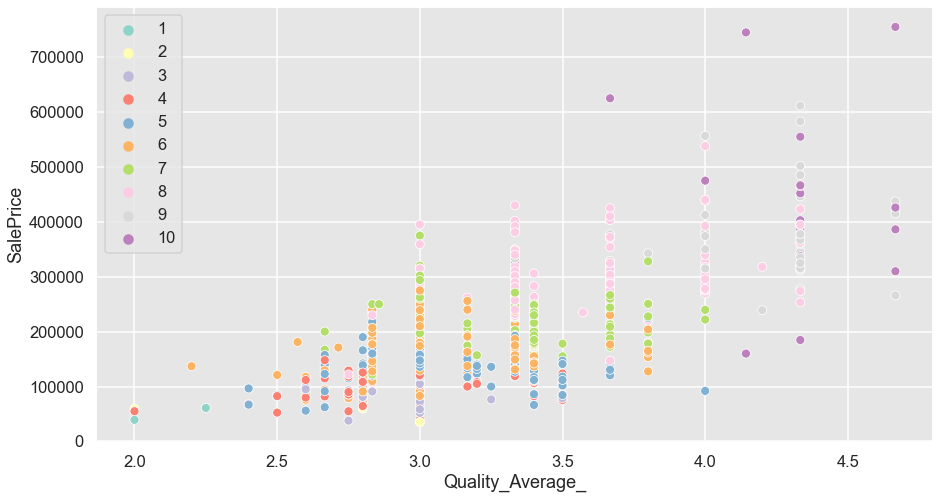

In [1776]:
plt.figure(figsize=(15,8))

# Plot average quality to overall quality
sns.scatterplot(x='Quality_Average_', y='SalePrice', hue=train_df.OverallQual.tolist(),
            palette='Set3', data=train_df[['SalePrice', 'Quality_Average_']])
plt.show()

In [1777]:
# Garage area per car
#train_df['GarageAreaPerCar_'] = train_df.GarageArea / train_df.GarageCars 
#train_df.GarageAreaPerCar_.fillna(0, inplace=True) 

#test_df['GarageAreaPerCar_'] = test_df.GarageArea / test_df.GarageCars 
#test_df.GarageAreaPerCar_.fillna(0, inplace=True) 

#Age of garage
train_df['GarageAge_'] = train_df.YrSold - train_df.GarageYrBlt
test_df['GarageAge_'] = test_df.YrSold - test_df.GarageYrBlt

#Age of house
train_df['Age_'] = train_df.YrSold - train_df.YearBuilt
test_df['Age_'] = test_df.YrSold - test_df.YearBuilt

#Age of house remodelling
train_df['RemodelAge_'] = train_df.YrSold - train_df.YearRemodAdd
test_df['RemodelAge_'] = test_df.YrSold - test_df.YearRemodAdd

In [1778]:
# summing developed areas (indoor and outdoor)
train_df['IndoorArea_'] = train_df.GrLivArea + train_df.TotalBsmtSF + train_df.GarageArea
test_df['IndoorArea_'] = test_df.GrLivArea + test_df.TotalBsmtSF + test_df.GarageArea

train_df['OutdoorArea_'] = (train_df.WoodDeckSF + train_df.OpenPorchSF + train_df.EnclosedPorch +
                            train_df['3SsnPorch'] + train_df.ScreenPorch + train_df.MasVnrArea +
                            train_df.PoolArea)

test_df['OutdoorArea_'] = (test_df.WoodDeckSF + test_df.OpenPorchSF + test_df.EnclosedPorch +
                           test_df['3SsnPorch'] + test_df.ScreenPorch + test_df.MasVnrArea +
                           test_df.PoolArea)

train_df['DevelopedArea_'] = train_df.IndoorArea_+ train_df.OutdoorArea_
test_df['DevelopedArea_'] = test_df.IndoorArea_ + test_df.OutdoorArea_

train_df['LotAreaBySlope_'] = train_df.LotArea * train_df.LandSlope
test_df['LotAreaBySlope_'] = test_df.LotArea * test_df.LandSlope

train_df['LotAreaByContour_'] = train_df.LotArea * train_df.LandContour
test_df['LotAreaByContour_'] = test_df.LotArea * test_df.LandContour

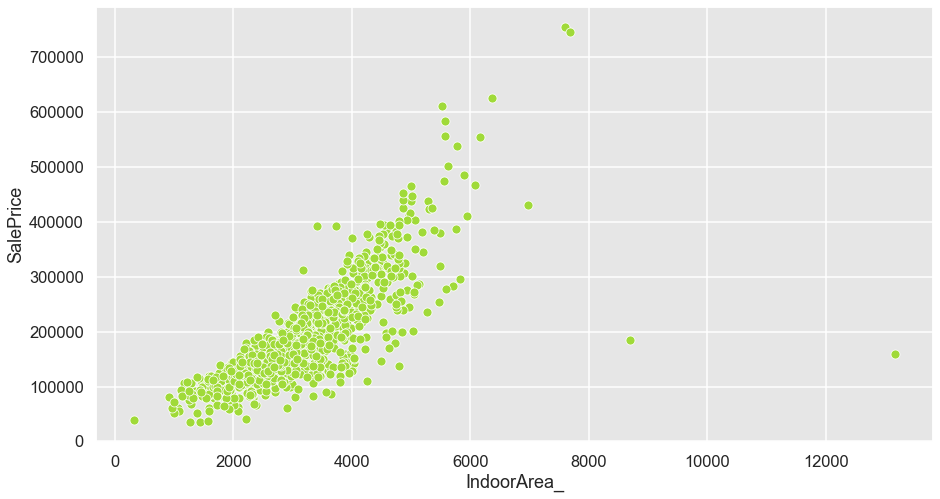

In [1779]:
plt.figure(figsize=(15,8))

# Plot total indoor area vs sale price of house
sns.scatterplot(x='IndoorArea_', y='SalePrice',
            data=train_df[['SalePrice', 'IndoorArea_']])
plt.show()

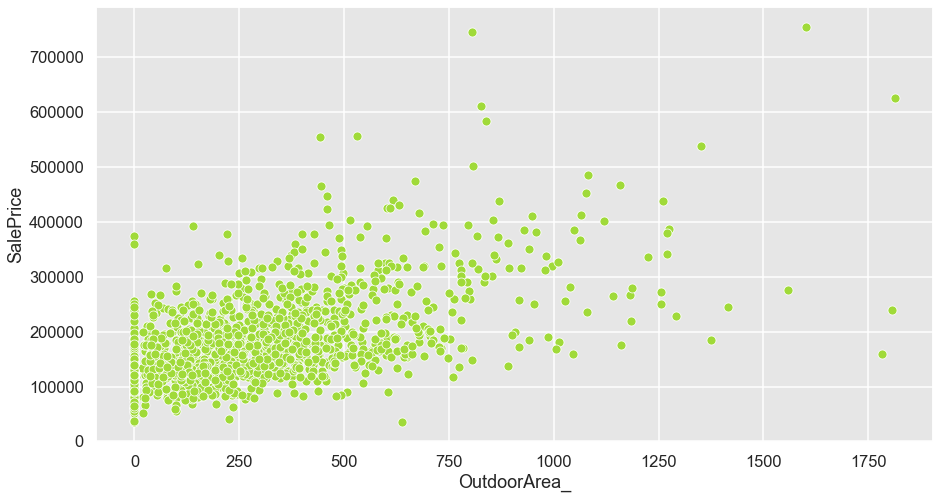

In [1780]:
plt.figure(figsize=(15,8))

# Plot total outdoor area vs sale price of house considering the building type
sns.scatterplot(x='OutdoorArea_', y='SalePrice',
            data=train_df[['SalePrice', 'OutdoorArea_']])
plt.show()

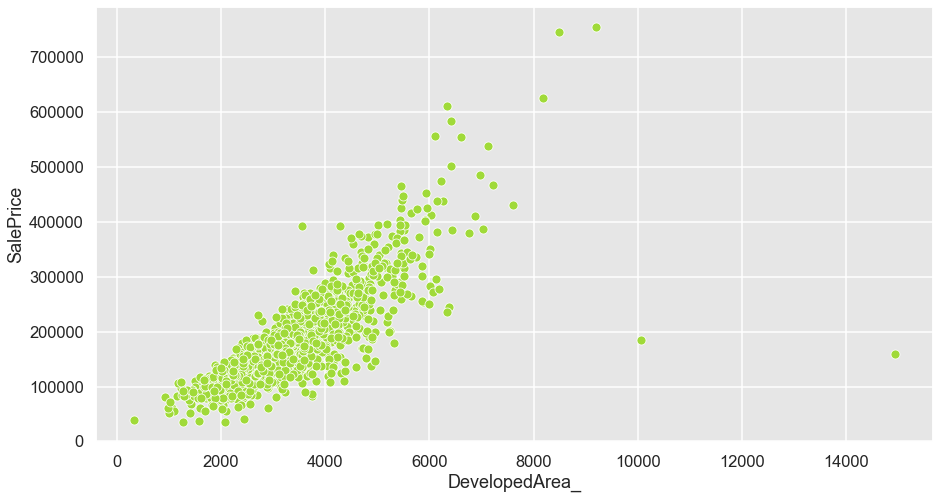

In [1781]:
plt.figure(figsize=(15,8))

# Plot total area that has been built out (nothing has been built on it) vs sale price of house
# considering the building type
sns.scatterplot(x='DevelopedArea_', y='SalePrice',
            data=train_df[['SalePrice', 'DevelopedArea_']])
plt.show()

In [1782]:
train_df['IsNew_'] = train_df.Age_.map(lambda x: 0 if x > 0 else 1)
test_df['IsNew_'] = test_df.Age_.map(lambda x: 0 if x > 0 else 1)

train_df['IsRemodelled_'] = train_df.RemodelAge_.map(lambda x: 0 if x > 0 else 1)
test_df['IsRemodelled_'] = test_df.RemodelAge_.map(lambda x: 0 if x > 0 else 1)

In [1783]:
train_df['TotalBathRms_'] = (train_df.FullBath + (train_df.HalfBath * 0.5) +
                             train_df.BsmtFullBath + (train_df.BsmtHalfBath * 0.5))
    
test_df['TotalBathRms_'] = (test_df.FullBath + (test_df.HalfBath * 0.5) +
                            test_df.BsmtFullBath + (test_df.BsmtHalfBath * 0.5))

In [1784]:
#train_df['HasPool_'] = train_df.PoolArea.map(lambda x: 0 if x == 0 else 1)
#test_df['HasPool_'] = test_df.PoolArea.map(lambda x: 0 if x == 0 else 1)

train_df['HasFireplace_'] = train_df.Fireplaces.map(lambda x: 0 if x == 0 else 1)
test_df['HasFireplace_'] = test_df.Fireplaces.map(lambda x: 0 if x == 0 else 1)

### Selecting Features

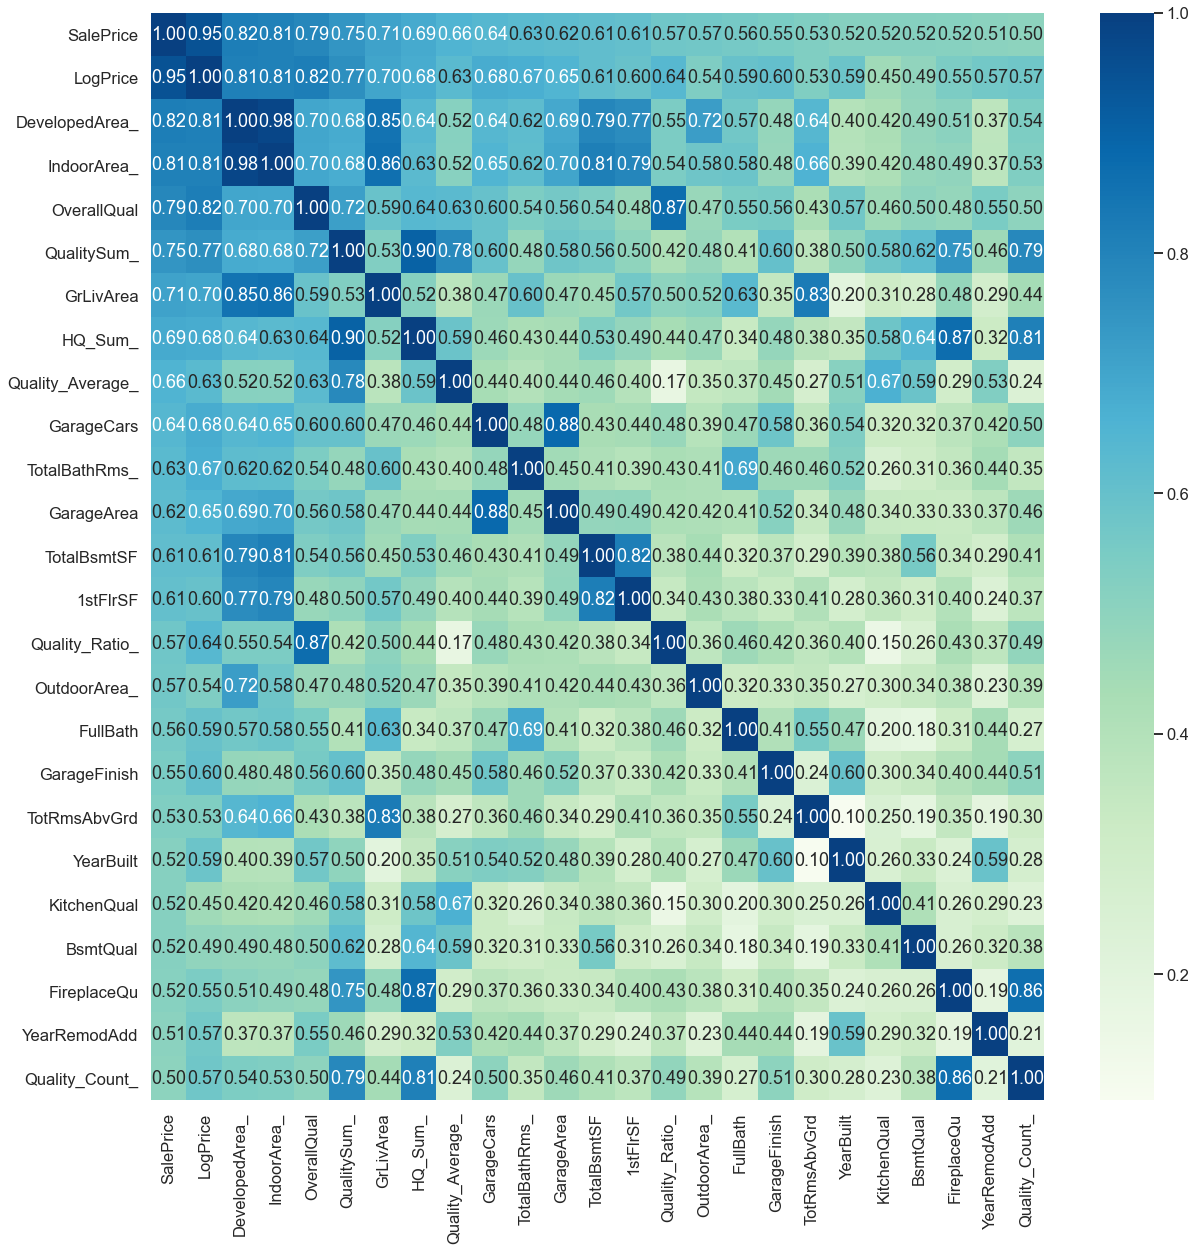

In [1785]:
corr = train_df.corr()
highest_corr_cols = corr[abs((corr.SalePrice)>=.50)].SalePrice.sort_values(ascending=False).keys()
highest_corr = corr.loc[highest_corr_cols, highest_corr_cols]
plt.figure(figsize=(20, 20))
sns.heatmap(highest_corr, cmap='GnBu', annot=True, fmt='.2f')
plt.show()
del corr, highest_corr

In [1786]:
features = list(['SalePrice', 'QualitySum_', 'Quality_Ratio_', 'Quality_Average_', 'GarageAge_', 'Age_', 'RemodelAge_',
                 'IndoorArea_', 'OutdoorArea_', 'LotAreaBySlope_', 'LotAreaByContour_',
                 'DevelopedArea_', 'IsNew_', 'IsRemodelled_', 'TotalBathRms_', 'HasFireplace_'])
corr = train_df[features].corr()['SalePrice']
print(corr)

SalePrice            1.000000
QualitySum_          0.748461
Quality_Ratio_       0.573116
Quality_Average_     0.657084
GarageAge_          -0.261441
Age_                -0.523350
RemodelAge_         -0.509079
IndoorArea_          0.807518
OutdoorArea_         0.569425
LotAreaBySlope_      0.375575
LotAreaByContour_    0.354396
DevelopedArea_       0.816964
IsNew_               0.224807
IsRemodelled_        0.335975
TotalBathRms_        0.631731
HasFireplace_        0.471908
Name: SalePrice, dtype: float64


In [1787]:
# Revisitng correlation with addition of new features 
corr = train_df.corr().abs().unstack().sort_values(ascending=False)['SalePrice']
corr = pd.DataFrame(corr, columns = ['Correlation'])
corr.Correlation.head(50)

#corr = corr[corr.Correlation > 0.50]
#corr

SalePrice            1.000000
LogPrice             0.948374
DevelopedArea_       0.816964
IndoorArea_          0.807518
OverallQual          0.790982
QualitySum_          0.748461
GrLivArea            0.708624
HQ_Sum_              0.687830
Quality_Average_     0.657084
GarageCars           0.640409
TotalBathRms_        0.631731
GarageArea           0.623431
TotalBsmtSF          0.613581
1stFlrSF             0.605852
Quality_Ratio_       0.573116
OutdoorArea_         0.569425
FullBath             0.560664
GarageFinish         0.549247
TotRmsAbvGrd         0.533723
Age_                 0.523350
YearBuilt            0.522897
KitchenQual          0.521284
BsmtQual             0.521268
FireplaceQu          0.518825
RemodelAge_          0.509079
YearRemodAdd         0.507101
Quality_Count_       0.504059
MasVnrArea           0.472614
HasFireplace_        0.471908
Fireplaces           0.466929
ExterQual            0.463465
HeatingQC            0.437640
BsmtFinSF1           0.386420
LotAreaByS

## Modelling

In [1788]:
train_df.reset_index(drop=True, inplace=True)

y = np.log(train_df['SalePrice'])
X = train_df.drop(['SalePrice', 'LogPrice'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rescaledX_train = preprocessing.scale(X_train)
rescaledX_test = preprocessing.scale(X_test)

### Linear Regression:

In [1789]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_LiR = lr_model.predict(X_test)

# The coefficients
print('Coefficients: \n', lr_model.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(np.exp(y_test), np.exp( y_pred_LiR)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(np.exp(y_test), np.exp(y_pred_LiR)))

# The MAPE: 0 is perfect prediction
print('MAPE: %.2f'
      % np.mean(np.abs((np.exp(y_test) - np.exp(y_pred_LiR)) / np.exp(y_test))))

Coefficients: 
 [-8.87893308e-04 -2.19803508e-04  1.59965321e-06  1.19198742e-03
 -2.42991163e-02 -1.06956900e-02  8.04089992e-02  3.15440970e-02
  2.53758640e-04  2.08368303e-04 -2.55473262e-04 -3.53627211e-03
 -4.94597192e-02  2.19631813e-02  6.11459073e-02  1.74826465e-02
  1.38567257e-02 -4.37391342e-05 -8.38845491e-03  2.55304724e-05
 -1.72526757e-05 -3.54613374e-05  1.67634017e-02  3.55149409e-02
 -1.35570749e-05 -3.64596885e-05  1.56514845e-04  1.06498081e-04
  1.53328390e-02 -3.75823150e-04  1.27253790e-02  2.36412701e-02
  5.09657187e-03 -1.86964292e-02 -3.90694230e-03  1.08564299e-02
  2.50540994e-02  3.10925020e-02  1.23457010e-02 -3.07959771e-04
  5.31057862e-03  6.47951462e-02 -7.99506230e-05  1.63664882e-02
 -2.82116380e-03  2.16787922e-02 -1.28510689e-04 -3.26162267e-04
  7.56240443e-06  2.45480076e-05  1.54126278e-04  6.32943236e-04
 -1.39198745e-01 -2.51518985e-03 -7.33394815e-06  1.85116864e-03
 -8.12643190e-04  6.63122469e-04 -7.92031872e-02 -1.31887173e-01
  4.01404

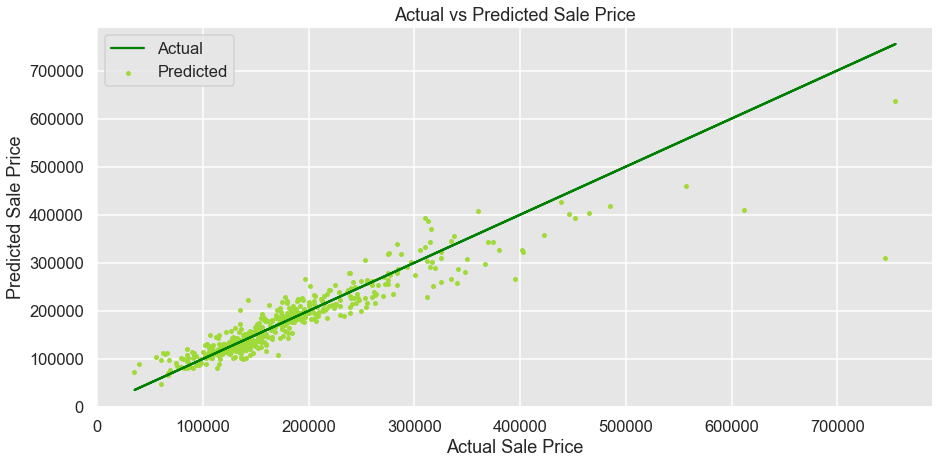

In [1790]:
# plot prediction and actual data
plt.figure(figsize=(15,7))
plt.scatter(np.exp(y_test), np.exp( y_pred_LiR), label='Predicted', s=12)
plt.plot(np.exp(y_test), np.exp(y_test), label='Actual', color='g')

plt.title('Actual vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()
plt.show()

### Kernel Ridge Regression

In [1791]:
kernelRidge = KernelRidge(alpha=0.1, degree=2, coef0=1.3)
kernelRidge_model = kernelRidge.fit(X_train, y_train)
y_pred_KRM = kernelRidge_model.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(np.exp(y_test), np.exp(y_pred_KRM)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(np.exp(y_test), np.exp(y_pred_KRM)))

# The MAPE: 0 is perfect prediction
print('MAPE: %.2f'
      % np.mean(np.abs((np.exp(y_test) - np.exp(y_pred_KRM)) / np.exp(y_test))))

Mean squared error: 1152137684.31
Coefficient of determination: 0.84
MAPE: 0.11


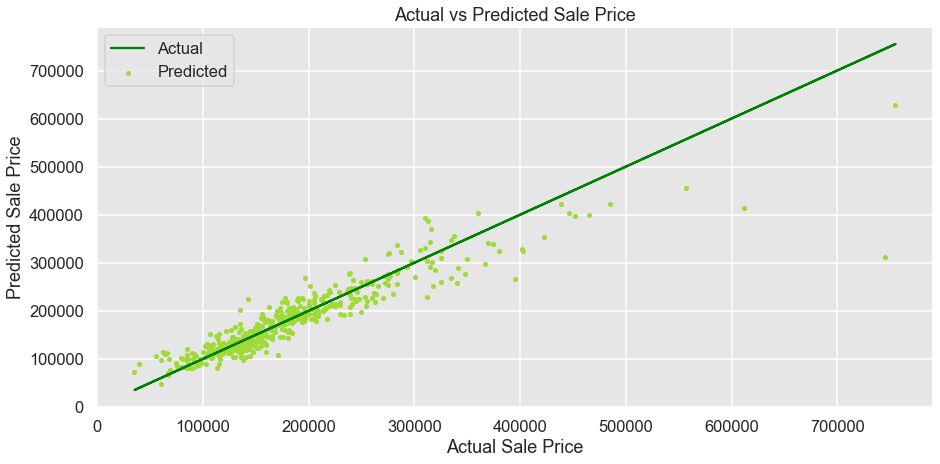

In [1792]:
# plot prediction and actual data
plt.figure(figsize=(15,7))
#Display number in decimal form, not scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.scatter(np.exp(y_test), np.exp(y_pred_KRM), label='Predicted', s=13)
plt.plot(np.exp(y_test), np.exp(y_test), label='Actual', color='g')

plt.title('Actual vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()
plt.show()

### Gradient Boost Regression

In [1793]:
gbr = GradientBoostingRegressor(random_state=42, subsample = 0.6, max_features=10, min_samples_split=4,
                                n_estimators=3000, learning_rate = 0.01)
gradientBoosting_model = gbr.fit(X_train, y_train)

y_pred_GBR = gradientBoosting_model.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(np.exp(y_test), np.exp(y_pred_GBR)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(np.exp(y_test), np.exp(y_pred_GBR)))

# The MAPE: 0 is perfect prediction
print('MAPE: %.2f'
      % np.mean(np.abs((np.exp(y_test) - np.exp(y_pred_GBR)) / np.exp(y_test))))

Mean squared error: 1034303217.70
Coefficient of determination: 0.86
MAPE: 0.09


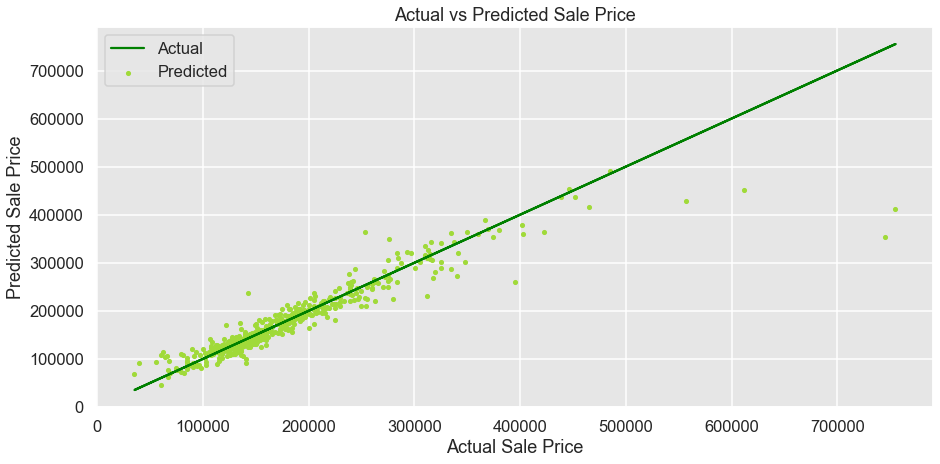

In [1794]:
# plot prediction and actual data
plt.figure(figsize=(15,7))
#Display number in decimal form, not scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.scatter(np.exp(y_test), np.exp(y_pred_GBR), label='Predicted', s=13)
plt.plot(np.exp(y_test), np.exp(y_test), label='Actual', color='g')

plt.title('Actual vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()
plt.show()

In [1795]:
#Independent Variable
X = train_df.loc[:,~train_df.columns.isin(['SalePrice'])]
X_scaled = preprocessing.scale(X)

#Dependent Variable
y = train_df.loc[:,'SalePrice']

# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import VarianceThreshold

# X = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X.fit_transform(XData)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 42)

### Data normalization and standardization

In [1796]:
#Data normalization and standardization
rescaledX_train = preprocessing.scale(X_train)
rescaledX_test = preprocessing.scale(X_test)

### Logestic Regression

In [1797]:
logReg = LogisticRegression(random_state = 42,solver='lbfgs', max_iter=300000)
logReg.fit(rescaledX_train,y_train)

LogisticRegression(max_iter=300000, random_state=42)

In [1798]:
#Model1 Evalution

y_pred = logReg.predict(rescaledX_test)
print('Accuracy of logistic regression classifier:', accuracy_score(y_test,y_pred))
# print('Roc Auc Score:',roc_auc_score(y_test,y_pred))
print('Confusion Matrix of the logreg model: ',confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier: 0.010273972602739725
Confusion Matrix of the logreg model:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### SVM

In [1799]:
classification_svm =svm.SVC()
classification_svm.fit(rescaledX_train,y_train)

SVC()

In [1800]:
y_pred = classification_svm.predict(rescaledX_test)

print('Accuracy of SVM classifier:', accuracy_score(y_test,y_pred))
# print('Roc Auc Score:',roc_auc_score(y_test,y_pred))
print('Confusion Matrix of the SVM model: ',confusion_matrix(y_test,y_pred))

Accuracy of SVM classifier: 0.015410958904109588
Confusion Matrix of the SVM model:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### KNN

In [1801]:
#train_filled_knn = KNN(k=1).fit_transform(train_df)   
#train_df = pd.DataFrame(train_filled_knn, columns = list(train_df.columns))
#train_df.head()

#test_filled_knn = KNN(k=1).fit_transform(test_df)   
#test_df = pd.DataFrame(test_filled_knn, columns = list(test_df.columns))
#test_df.head()

## Submission

In [1802]:
#JUST USING LINEAR AS A PLACEHOLDER UNTIL THE FINAL MODEL IS CHOSEN
test_df.reset_index(drop=True, inplace=True)
y_pred_results = gradientBoosting_model.predict(test_df)

#Prediction results in the format of house id and sale price (see sample_submission.csv for formatting)
test_results = pd.DataFrame(columns=['Id', 'SalePrice'])
test_results['Id'] = test_df_Id
test_results['SalePrice'] = np.exp(y_pred_results)

test_results.to_csv('PyLovers_FinalProject.csv', index = False)
test_results.head()

,Id,SalePrice
0,1461,121640.081942
1,1462,147021.542421
2,1463,177110.767646
3,1464,188695.596744
4,1465,177497.150147
